In [268]:
import os
import glob

import cv2

from ana_classification.presentation import display_grid, ImagePlotter, HistogramPlotter, LayerPlotter
from ana_classification.preprocessing import preprocess, _equalize_histogram

from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage.morphology as morph
from skimage import measure
from scipy.ndimage import gaussian_gradient_magnitude, sobel, distance_transform_edt
from skimage.transform import hough_ellipse
from skimage.feature import canny
from skimage import feature
from skimage.morphology import watershed

In [187]:
paths = list(sorted(glob.glob('data/samples/ACA*')))
titles = [os.path.splitext(os.path.basename(p))[0] for p in paths]
size = (800, 600)
denoise_h = 2
paths

['data/samples/ACA-1.png', 'data/samples/ACA-2.tif', 'data/samples/ACA-3.tif']

In [188]:
%%time
imgs = [preprocess(cv2.imread(p)) for p in paths]

CPU times: user 4.8 s, sys: 0 ns, total: 4.8 s
Wall time: 1.36 s


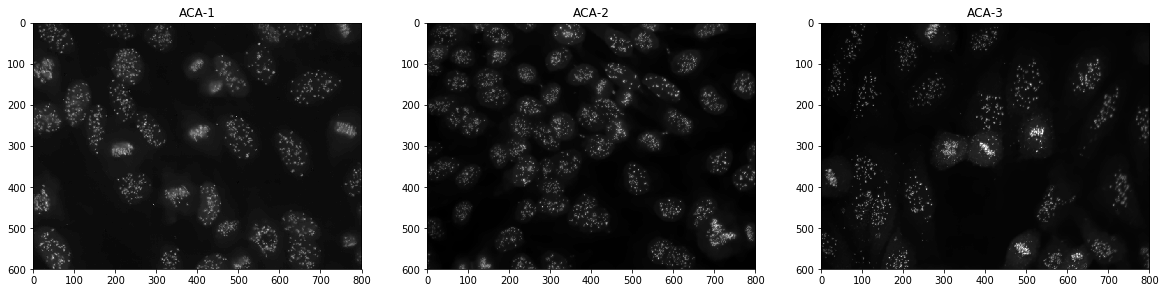

In [189]:
display_grid(imgs, ImagePlotter(), titles)

In [192]:
imgs_equalized = [_equalize_histogram(img.astype(np.uint8)) for img in imgs]

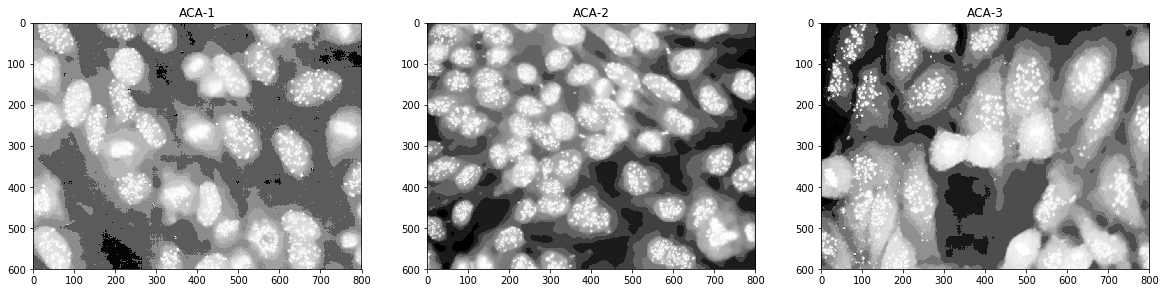

In [193]:
display_grid(imgs_equalized, ImagePlotter(), titles)

In [172]:
def test(im, fraction=0.9):
    return im > fraction*np.amax(im)

In [173]:
def local_spreckles(img, struct, stride, max_fraction, basic_threshold=0.7):
    roi_mask = np.zeros(bin_img.shape)
    img_h, img_w = bin_img.shape
    struct_h, struct_w = struct.shape

    y = 0
    while y + struct_h <= img_h:
        x = 0
        while x + struct_w <= img_w:
            img_slice = bin_img[y:y+struct_h, x:x+struct_w]
            s = np.std(img_slice[struct == 1])
            if s >= std_th:
                roi_mask[y:y+struct_h, x:x+struct_w][struct == 1] = 1
                
            x += stride
            
        y += stride
        
    return roi_mask

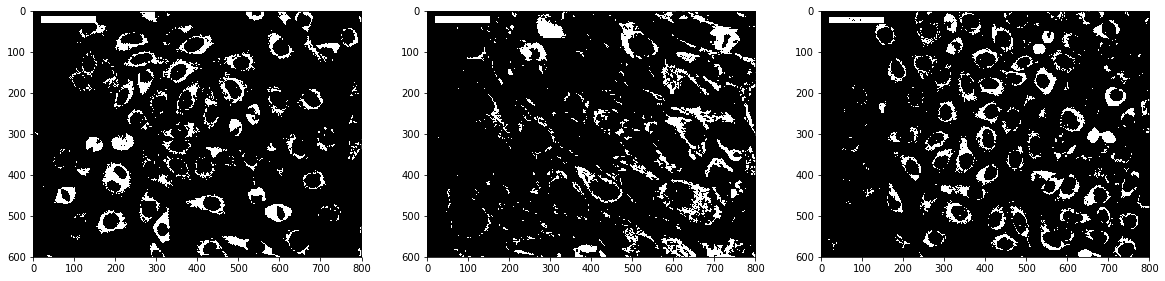

In [174]:
tests = [test(i) for i in imgs_equalized]
display_grid(tests, ImagePlotter())

In [203]:
def heat_map(img, kernel):
    hm = np.zeros(img.shape)
    
    kernel_y_offset = kernel.shape[0] // 2
    kernel_x_offset = kernel.shape[1] // 2
    
    y_lim = img.shape[0] - kernel.shape[0]
    x_lim = img.shape[1] - kernel.shape[1]
    
    for y in range(y_lim):
        for x in range(x_lim):
            img_slice = img[y:y+kernel.shape[0], x:x+kernel.shape[1]]
            count = np.sum(img_slice * kernel)
            hm[y + kernel_y_offset][x + kernel_x_offset] = count
            
    return hm

In [204]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (25, 25))
heatmaps = [heat_map(i, kernel) for i in imgs_equalized]

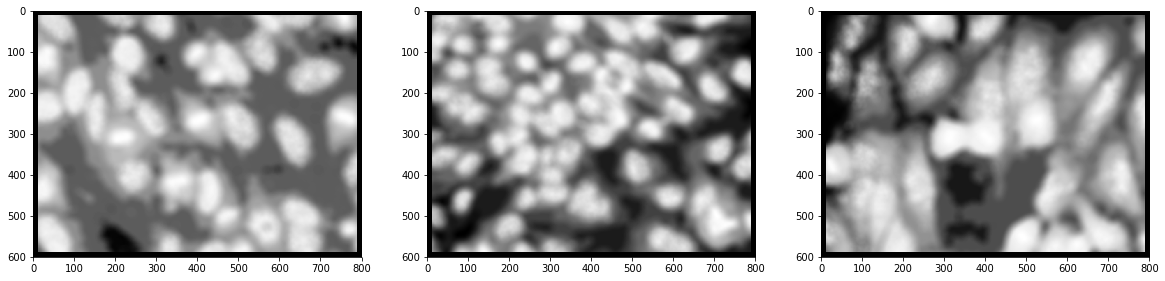

In [205]:
display_grid(heatmaps, ImagePlotter())

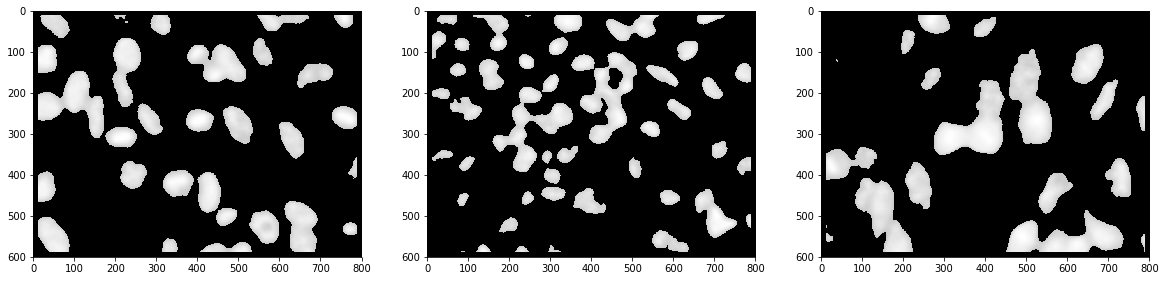

In [210]:
threshold = 95*1000
hm_with_threshold = [hm * (hm > threshold) for hm in heatmaps]
display_grid(hm_with_threshold, ImagePlotter())

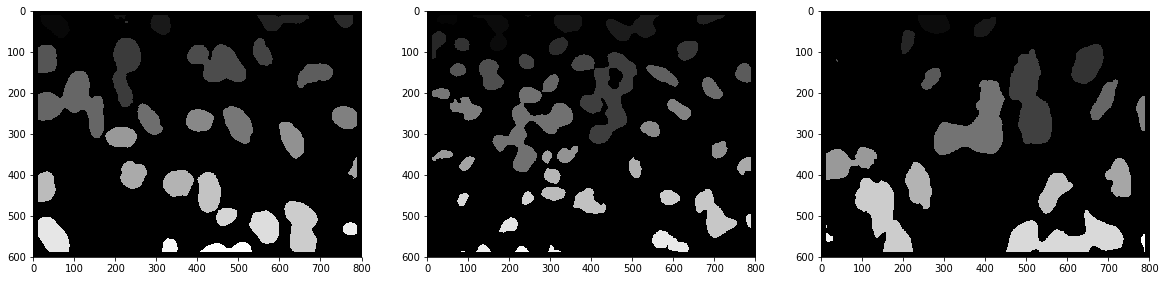

In [213]:
labeled = [measure.label(i > 0) for i in hm_with_threshold]
display_grid(labeled, ImagePlotter())

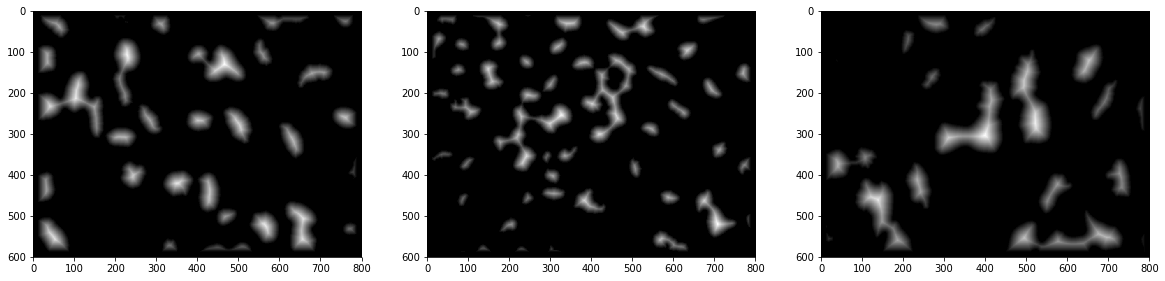

In [305]:
dists = [distance_transform_edt(roi > 0) for roi in labeled]
display_grid(dists, ImagePlotter())

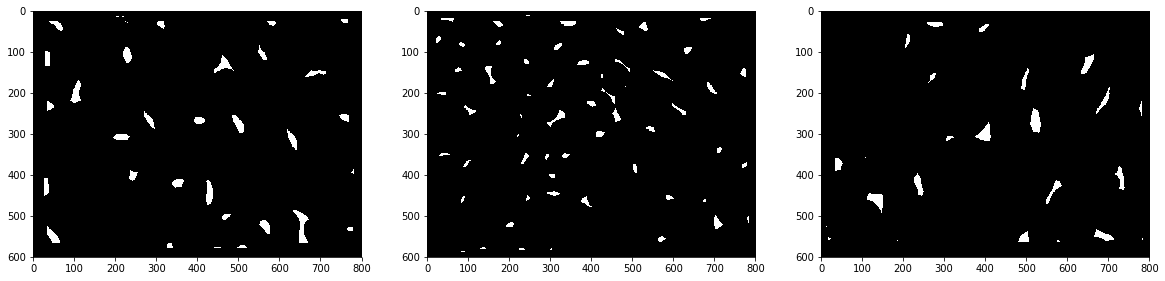

In [326]:
peak_threshold = 0.7


props = [measure.regionprops(l) for l in labeled]

markers = []

for img_props, dist in zip(props, dists):
    
    new_marker = np.zeros(dist.shape)
    
    for p in img_props:
        c = p.coords
        region = dist[c[:, 0], c[:, 1]]
        max_peak = np.amax(dist[c[:, 0], c[:, 1]])
        new_marker[c[:, 0], c[:, 1]] = dist[c[:, 0], c[:, 1]] > peak_threshold * max_peak
        
    markers.append(new_marker)
    
display_grid(markers, ImagePlotter())

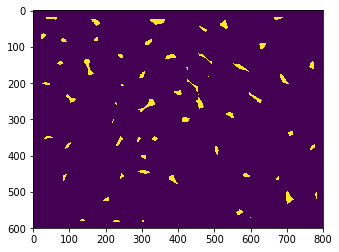

In [327]:
sample = markers[1]
plt.imshow(sample)

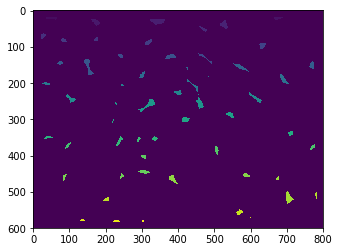

In [328]:
_, mm = cv2.connectedComponents(sample.astype(np.uint8))
# markers[markers > 0] += 10
plt.imshow(mm)

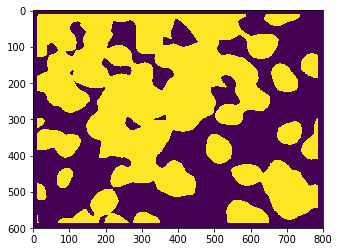

In [337]:
fg = heatmaps[1] > 60*1000
plt.imshow(fg)

In [338]:
water = watershed(fg, mm)
water

array([[60, 60, 60, ..., 60, 60, 60],
       [60, 60, 60, ..., 60, 60, 60],
       [60, 60, 60, ..., 60, 60, 60],
       ...,
       [60, 60, 60, ..., 60, 60, 60],
       [60, 60, 60, ..., 60, 60, 60],
       [60, 60, 60, ..., 60, 60, 60]], dtype=int32)

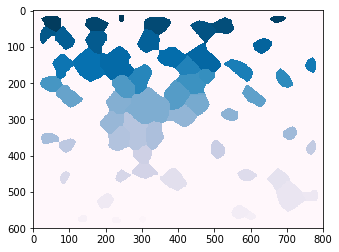

In [339]:
plt.imshow(water, cmap='PuBu_r')

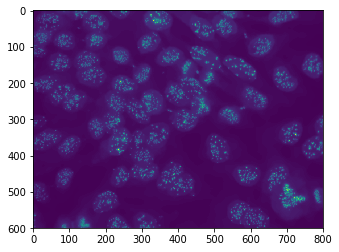

In [340]:
plt.imshow(imgs[1])

In [ ]:
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

In [243]:
contours, _ = cv2.findContours(a.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
edge = contours[0]

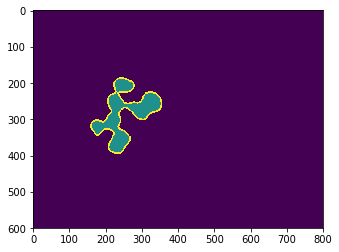

In [244]:
cv2.drawContours(a, [edge], 0, 2, 3)
plt.imshow(a)

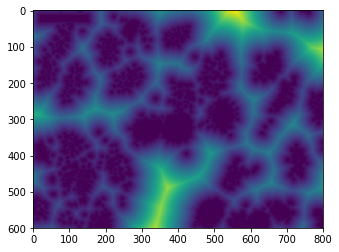

In [133]:
d = distance_transform_edt(s)
plt.imshow(d * s)

In [136]:
a = (d * s)
a

array([[25.        , 24.20743687, 23.43074903, ..., 36.34556369,
        37.33630941, 38.32753579],
       [24.41311123, 23.60084744, 22.8035085 , ..., 36.22154055,
        37.21558813, 38.20994635],
       [23.85372088, 23.02172887, 22.20360331, ..., 36.12478374,
        37.12142239, 38.11823711],
       ...,
       [25.07987241, 24.69817807, 24.35159132, ...,  0.        ,
         0.        ,  0.        ],
       [26.        , 25.63201124, 25.29822128, ...,  0.        ,
         0.        ,  0.        ],
       [26.92582404, 26.57066051, 26.2488095 , ...,  0.        ,
         0.        ,  0.        ]])

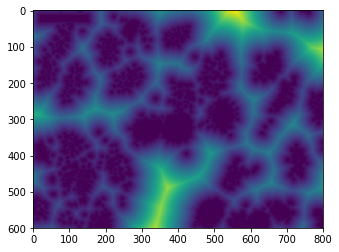

In [138]:
plt.imshow(d)

In [99]:
def detect_std_roi(bin_img, struct, stride, std_th):
    roi_mask = np.zeros(bin_img.shape)

    
    img_h, img_w = bin_img.shape
    struct_h, struct_w = struct.shape

    y = 0
    while y + struct_h <= img_h:
        x = 0
        while x + struct_w <= img_w:
            img_slice = bin_img[y:y+struct_h, x:x+struct_w]
            s = np.std(img_slice[struct == 1])
            if s >= std_th:
                roi_mask[y:y+struct_h, x:x+struct_w][struct == 1] = 1
                
            x += stride
            
        y += stride
        
    return roi_mask

In [108]:
st = struct = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))

a = detect_std_roi(imgs_equalized[0], st, 5, 20)

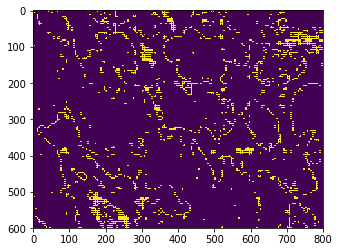

In [109]:
plt.imshow(a)

## thresholding

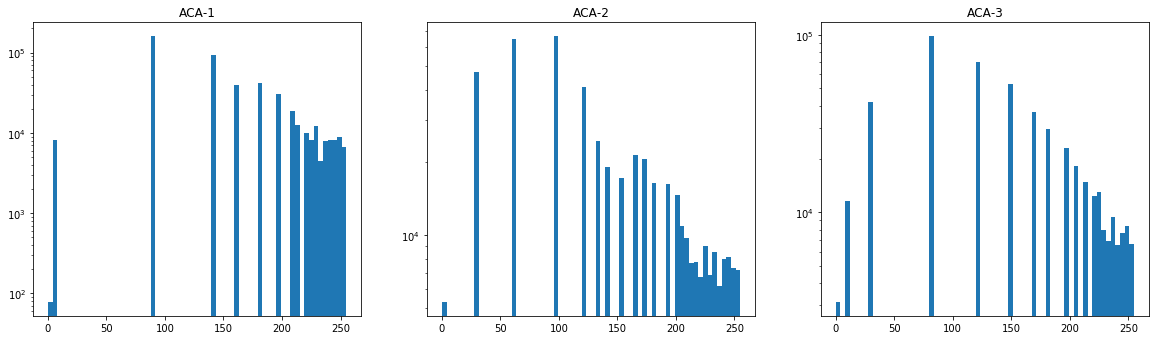

In [21]:
display_grid(imgs_equalized, HistogramPlotter(), titles)

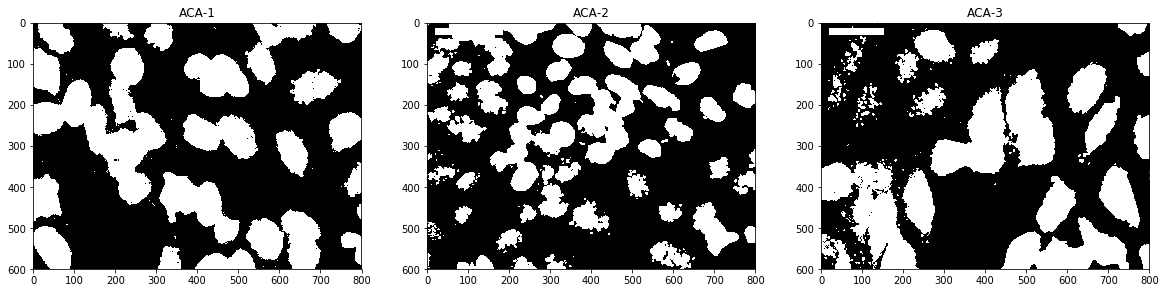

In [75]:
threshold = 0.7
threshed = [i > threshold * 255 for i in imgs_equalized]
display_grid(threshed, ImagePlotter(), titles)

## detecting regions of interest

In [76]:
def detect_roi(bin_img, struct, stride, fill_fraction):
    roi_mask = np.zeros(bin_img.shape)
    fill_threshold = fill_fraction * np.sum(struct)
    
    img_h, img_w = bin_img.shape
    struct_h, struct_w = struct.shape

    y = 0
    while y + struct_h <= img_h:
        x = 0
        while x + struct_w <= img_w:
            img_slice = bin_img[y:y+struct_h, x:x+struct_w]
            area = np.sum(struct * img_slice)
            if area >= fill_threshold:
                roi_mask[y:y+struct_h, x:x+struct_w] = 1
                
            x += stride
            
        y += stride
        
    return roi_mask

In [79]:
struct = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(15,15))

rois = [detect_roi(i, struct, 5, 0.4) for i in threshed]

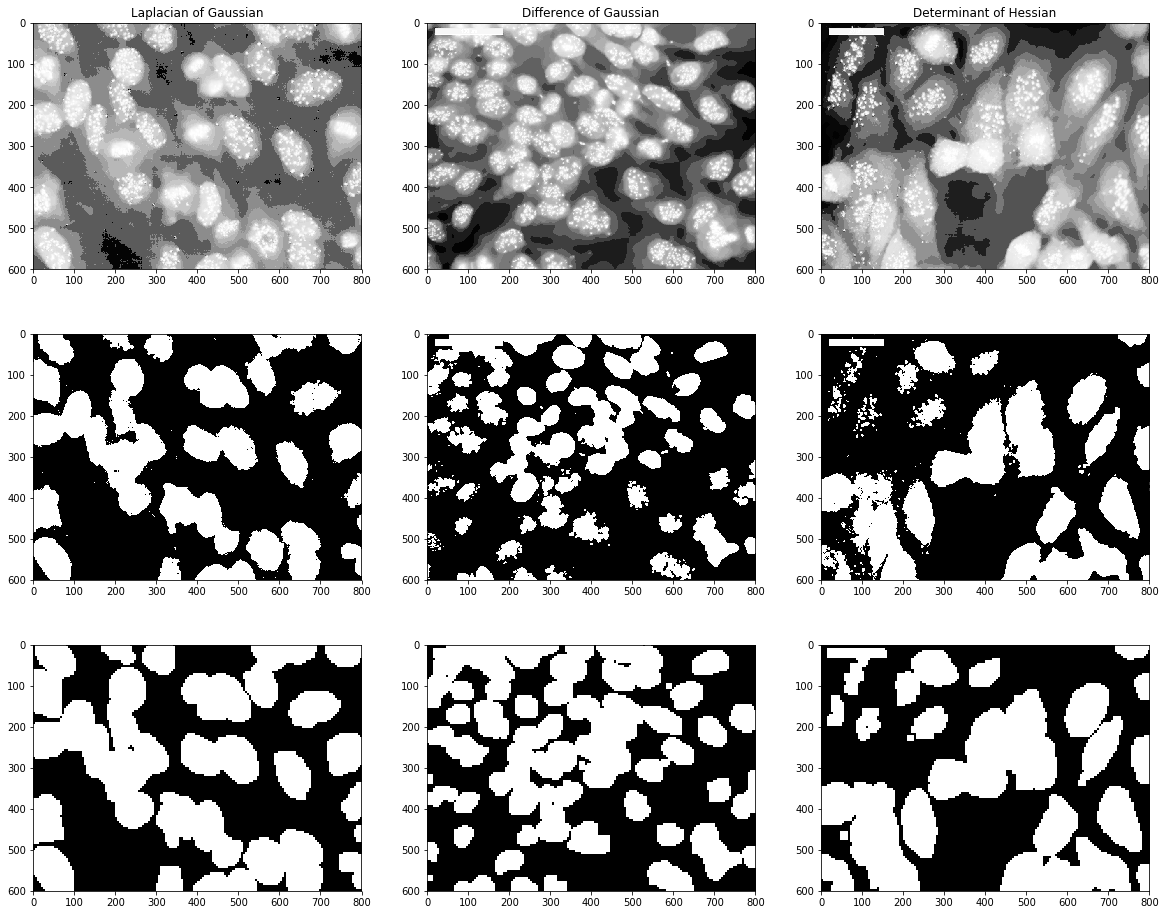

In [93]:
display_grid(imgs_equalized + threshed + rois, ImagePlotter(), titles)

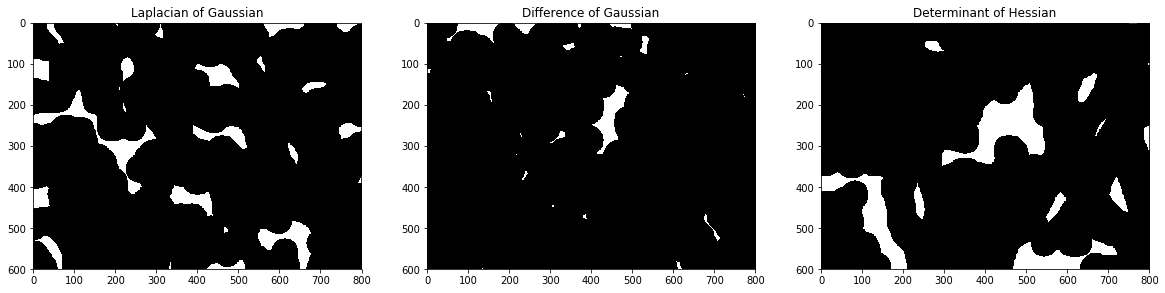

In [97]:
dist = [distance_transform_edt(i) > 30 for i in rois]
display_grid(dist, ImagePlotter(), titles)

## detecting split edges between overlapping cells

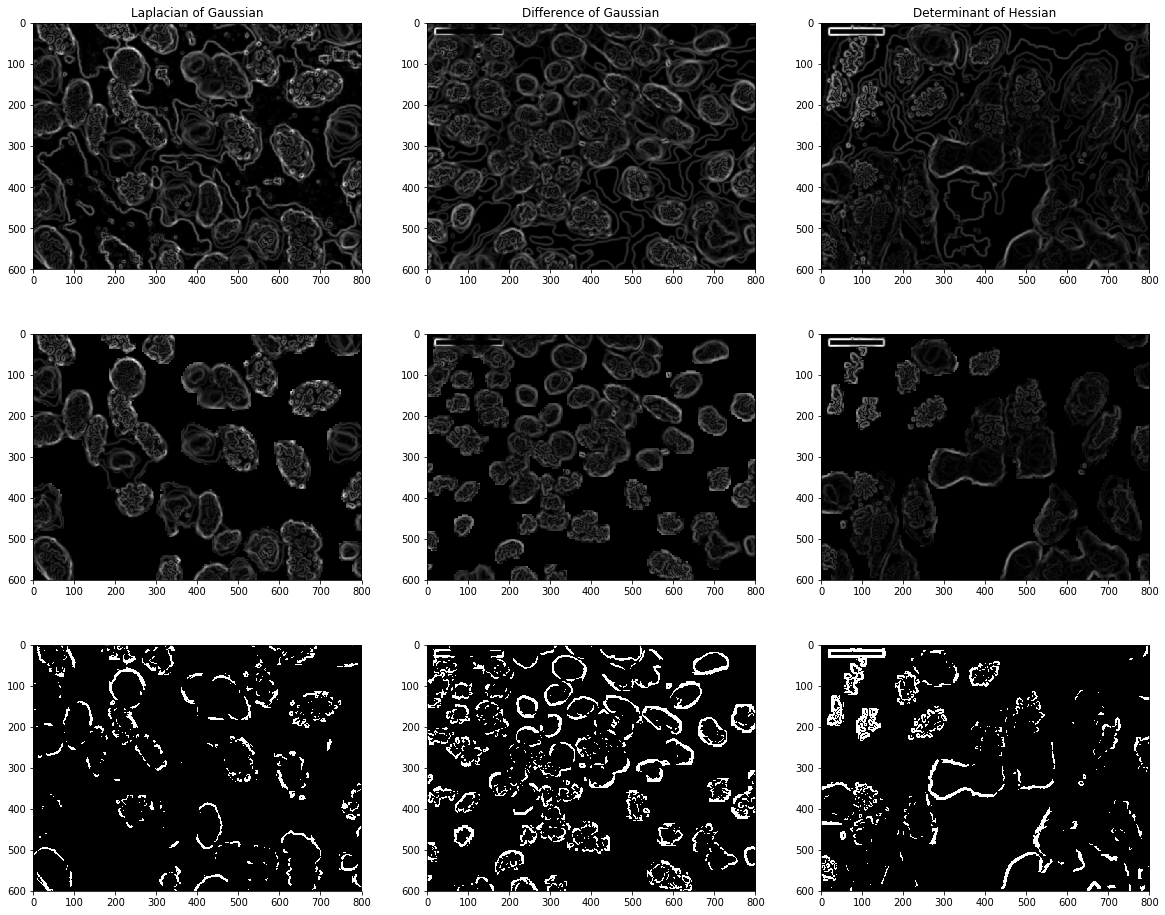

In [92]:
sigma = 2
gradients = [gaussian_gradient_magnitude(i / 255, sigma) for i in imgs_equalized]
covered = [g * m for g, m in zip(gradients, rois)]
cov_th = [c > 0.03 for c in covered]
display_grid(gradients + covered + cov_th, ImagePlotter(), titles)

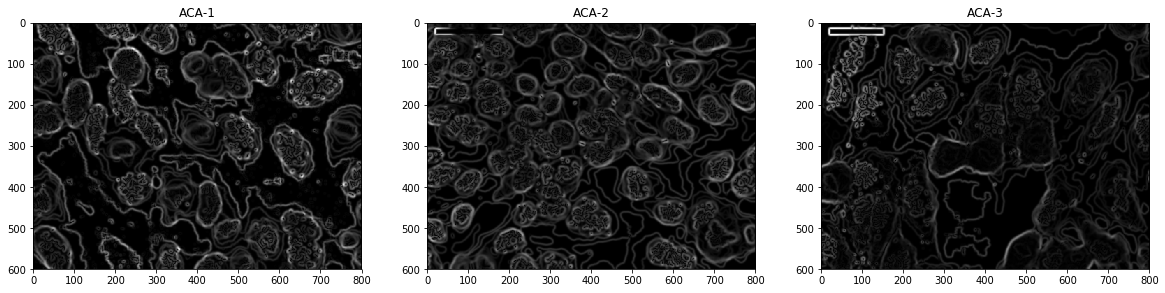

In [18]:
xd = [gaussian_gradient_magnitude(sample / 255, sigma=2) for sample in imgs_equalized]
display_grid(xd, ImagePlotter(), titles)

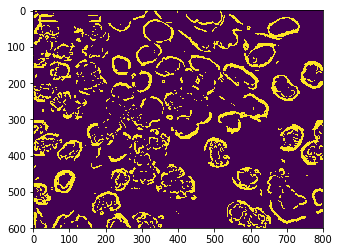

In [88]:
plt.imshow(gradients[1] > 0.03)

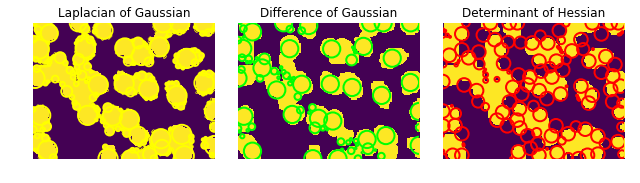

In [90]:
from math import sqrt

blobs_log = feature.blob_log(rois[0], max_sigma=30, num_sigma=10, threshold=.1)

# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = feature.blob_dog(rois[0], max_sigma=30, threshold=.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

blobs_doh = feature.blob_doh(rois[0], max_sigma=30, threshold=.01)

blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
          'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(rois[0])
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()

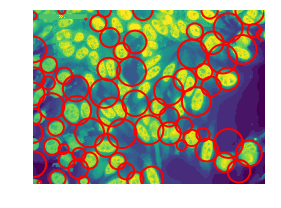

<Figure size 360x360 with 0 Axes>

In [71]:
blobs_doh = feature.blob_doh(sample, max_sigma=50, threshold=.005)

blobs_list = [blobs_doh]
colors = ['red']
titles = ['Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 1, figsize=(9, 3), sharex=True, sharey=True)
ax = axes

ax.imshow(sample)
for blob in blobs_doh:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
    ax.add_patch(c)
ax.set_axis_off()

plt.tight_layout()
plt.figure(figsize=(5, 5))
plt.show()

In [33]:
def adaptive(img, region, offset):
    thresh2 = cv2.adaptiveThreshold(img.astype(np.uint8),255,cv2.ADAPTIVE_THRESH_MEAN_C,
                                    cv2.THRESH_BINARY,region,offset)
    return img > thresh2

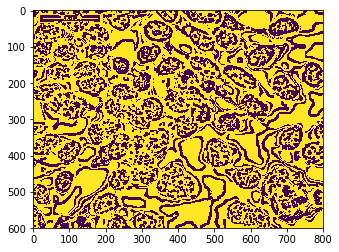

In [36]:
res = adaptive(imgs_equalized[1], 15, 0)
plt.imshow(res)

In [16]:
adapt = [adaptive(i) for i in imgs_equalized]

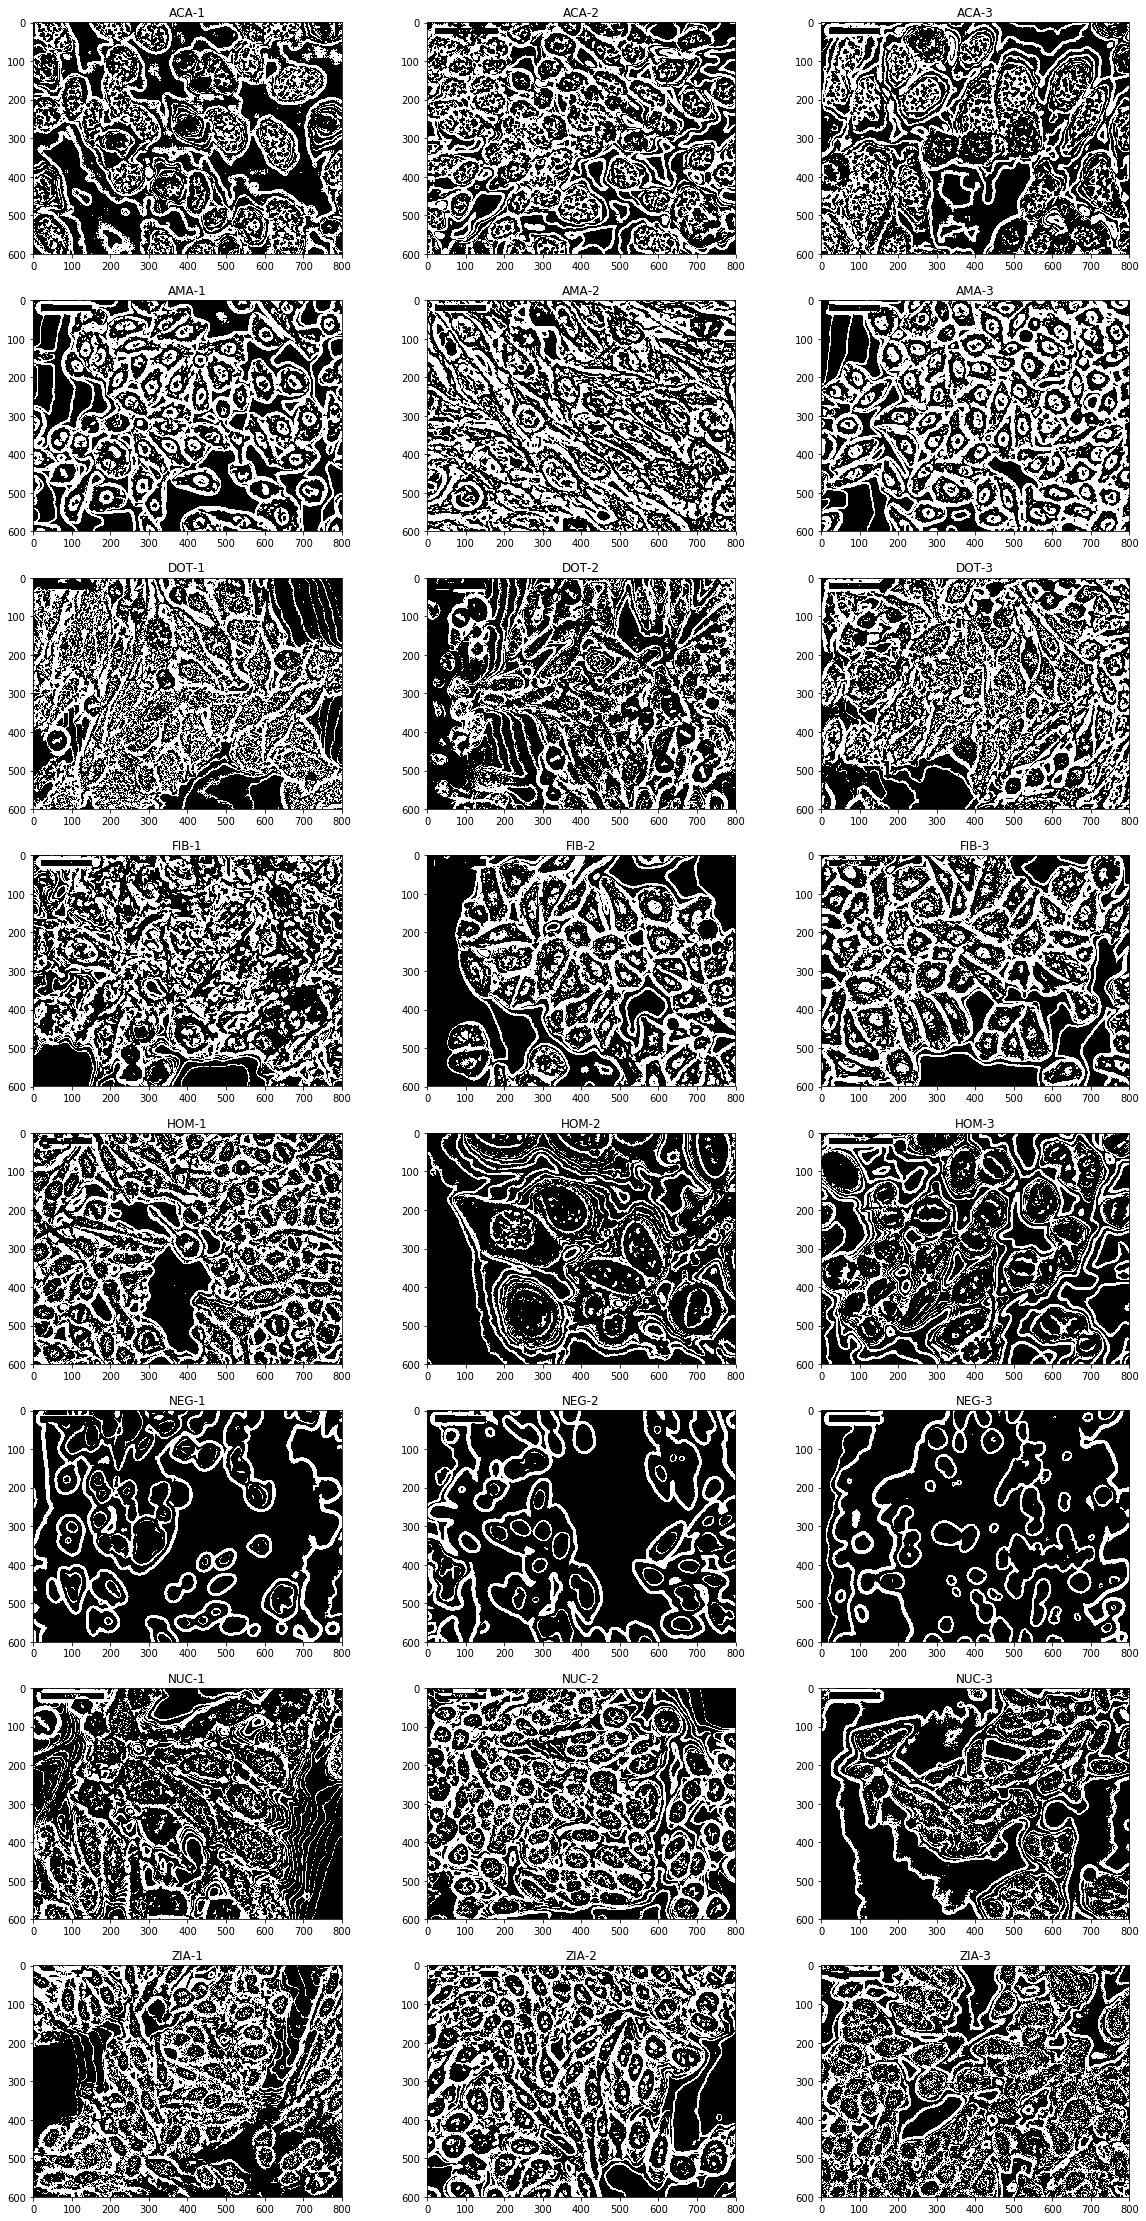

In [17]:
display_grid(adapt, ImagePlotter(), titles)